In [1]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-30 18:56:43.198676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 18:56:43.861090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [2]:
min_non_zero_pct = 0.5
window_size = 3
sequence_length = 10

df = load_and_merge()
df = remove_underpopulated_taxa(df, min_non_zero_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [3]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000000,0.000160,0.288889,0.000000,0.000000,0.242718,0.010256,0.190476,0.000000,0.100671,...,0.029412,0.000000,0.040201,0.455696,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000000,0.000160,0.200000,0.000000,0.000000,0.199029,0.007692,0.119048,0.000000,0.120805,...,0.117647,0.000000,0.035804,0.398734,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000000,0.000180,0.200000,0.003724,0.000000,0.228155,0.007692,0.023810,0.000000,0.053691,...,0.117647,0.000000,0.034338,0.518987,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.065636,0.000160,0.088889,0.016139,0.000000,0.121359,0.002564,0.023810,0.000000,0.080537,...,0.205882,0.000085,0.021566,0.386076,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.065636,0.000220,0.177778,0.017381,0.000000,0.490291,0.020513,0.071429,0.000000,0.053691,...,0.176471,0.000085,0.050251,0.386076,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.060355,0.080890,0.288889,0.007449,0.044379,0.111650,0.025641,0.476190,0.479017,0.503356,...,0.470588,0.055292,0.091290,0.253165,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.060355,0.120524,0.622222,0.010552,0.077663,0.194175,0.071795,0.404762,0.880928,0.711409,...,0.441176,0.071990,0.142169,0.341772,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.051679,0.141802,1.000000,0.011173,0.161243,0.436893,0.074359,0.619048,0.849198,0.906040,...,0.264706,0.057024,0.213358,0.373418,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.021124,0.127490,0.977778,0.004345,0.160503,0.572816,0.071795,0.571429,0.761174,0.899329,...,0.294118,0.037543,0.241625,0.316456,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


## Features and targets

In [4]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E006781' 'E013505' 'E012854']


In [5]:
print(len(train_feats), len(train_targets))

277 277


In [6]:
train_targets = np.asarray(train_targets)
train_targets = pd.DataFrame(train_targets)
train_targets.columns = df.columns[:-1]

In [7]:
train_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,922761,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day
0,0.004527,0.000360,0.200000,0.002483,0.110947,0.048544,0.043590,0.309524,0.050836,0.315436,...,0.173414,0.470588,0.126800,0.065955,0.037975,0.080118,0.171957,0.068966,0.867435,0.867435
1,0.000000,0.000000,0.000000,0.000000,0.002219,0.009709,0.000000,0.071429,0.003412,0.067114,...,0.000080,0.058824,0.004970,0.001047,0.031646,0.005537,0.004468,0.088670,0.642651,0.642651
2,0.051679,0.000841,0.288889,0.050900,0.082101,0.344660,0.307692,0.023810,0.000000,0.006711,...,0.002214,0.000000,0.019027,0.605946,0.183544,0.244160,0.178487,0.325123,0.642651,0.642651
3,0.000000,0.000280,0.311111,0.000621,0.105769,0.116505,0.007692,0.476190,0.293415,0.241611,...,0.005067,0.176471,0.117144,0.015285,0.246835,0.043087,0.307361,0.054187,0.533141,0.533141
4,0.001509,0.002362,0.111111,0.007449,0.003698,0.092233,0.030769,0.404762,0.172296,0.181208,...,0.000080,0.382353,0.022662,0.083124,0.025316,0.191210,0.409429,0.901478,0.420749,0.420749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0.027537,0.000520,0.000000,0.057728,0.130178,0.000000,0.133333,0.142857,0.000000,0.315436,...,0.005548,0.176471,0.000170,0.012772,0.000000,0.000173,0.000187,0.118227,0.334294,0.334294
273,0.018106,0.006806,0.133333,0.099938,0.015533,0.072816,0.030769,0.095238,0.084954,0.201342,...,0.000107,0.264706,0.000227,0.042085,0.012658,0.068351,0.071638,0.093596,0.354467,0.354467
274,0.000000,0.000380,0.333333,0.000000,0.022189,0.048544,0.253846,0.142857,0.030365,0.275168,...,0.000000,0.235294,0.026922,0.263400,0.069620,0.208514,0.314890,0.128079,0.553314,0.553314
275,0.002641,0.000100,0.933333,0.018001,0.134615,0.665049,0.069231,0.047619,0.000341,0.067114,...,0.009628,0.058824,0.045324,0.100921,0.886076,0.107804,0.076262,0.019704,0.510086,0.510086


## The model

In [8]:
def fetch_model(seq_length):

    reg = 1e-8
    
    n_feats = len(df.columns) - 1
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [9]:
def compile_model(model, loss):
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    return model

In [10]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [11]:
y_true = tf.constant([0])
y_pred = tf.constant([1])

loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss.call(y_true, y_pred)

2023-10-30 18:56:54.108272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 18:56:54.124813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 18:56:54.125062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

In [12]:
target_taxa = 364179

plot=False

if plot is True:
    plot_a_taxa_sequence(train_targets[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [13]:
n_epochs = 15

#loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss = "mae"

model = fetch_model(seq_length=sequence_length)
model = compile_model(model, loss)

model.fit(x=train_feats, y=train_targets[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/15


2023-10-30 18:56:57.912468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-30 18:56:57.942624: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f66f4b4e930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-30 18:56:57.942656: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-30 18:56:57.946352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-30 18:56:57.967425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-30 18:56:58.059568: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

9/9 [==============================] - 2s 36ms/step - loss: 7.6279 - mae: 0.0222 - mape: 17474.5801 - val_loss: 5.9562 - val_mae: 0.0797 - val_mape: 100.0000
Epoch 2/15
9/9 [==============================] - 0s 15ms/step - loss: 4.9582 - mae: 0.0219 - mape: 93.5361 - val_loss: 3.7898 - val_mae: 0.0797 - val_mape: 100.0000
Epoch 3/15
9/9 [==============================] - 0s 16ms/step - loss: 3.0955 - mae: 0.0219 - mape: 93.5361 - val_loss: 2.3395 - val_mae: 0.0797 - val_mape: 100.0000
Epoch 4/15
9/9 [==============================] - 0s 15ms/step - loss: 1.8736 - mae: 0.0219 - mape: 93.5361 - val_loss: 1.4181 - val_mae: 0.0797 - val_mape: 100.0000
Epoch 5/15
9/9 [==============================] - 0s 17ms/step - loss: 1.1101 - mae: 0.0219 - mape: 93.5361 - val_loss: 0.8573 - val_mae: 0.0797 - val_mape: 100.0000
Epoch 6/15
9/9 [==============================] - 0s 16ms/step - loss: 0.6515 - mae: 0.0219 - mape: 93.5361 - val_loss: 0.5275 - val_mae: 0.0797 - val_mape: 100.0000
Epoch 7/15
9

In [14]:
test_subjects

array(['E006781', 'E013505', 'E012854'], dtype=object)

In [15]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

test_subject_feats = np.asarray(test_feats[target_subject])

test_subject_targets = pd.concat(test_targets[target_subject]).T
test_subject_targets.columns = df.columns[:-1]

1/1 [==============================] - 0s 115ms/step


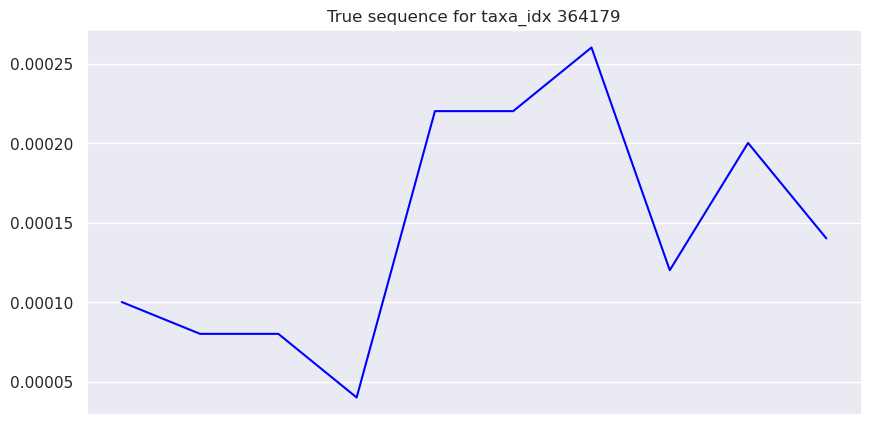

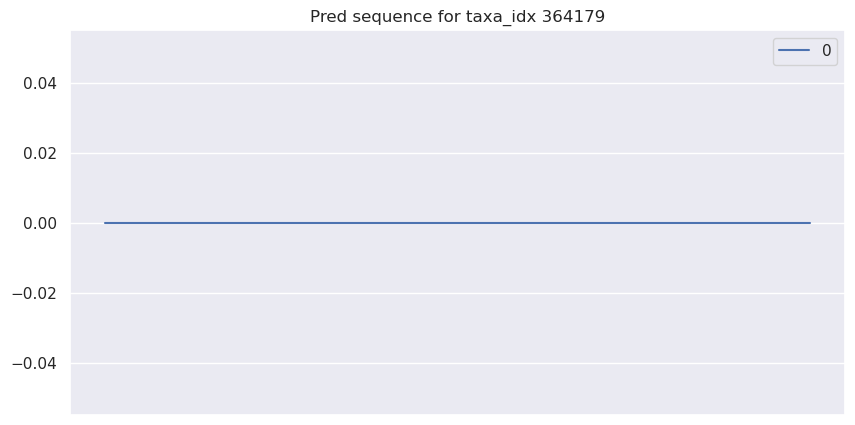

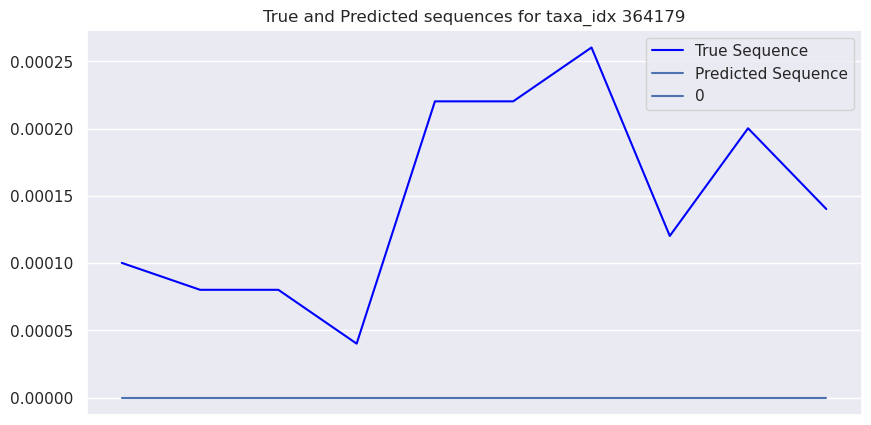

In [16]:
y_pred = model.predict(test_subject_feats)

true_sequence = test_subject_targets[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [17]:
class ensemble():
        
    def __init__(self, ensemble_name, loss, seq_length, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train
        self.loss = loss
        self.seq_length = seq_length

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        # hardcoded stuff
        ignore_cols = ["subject_id", "sampling_day", "ind_time"]
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            if taxa_idx not in ignore_cols:
            
                model = fetch_model(seq_length=self.seq_length)
                model = compile_model(model, loss)
                y_targets = y_targets_train[taxa_idx]
                model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
                
                model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
                del model
            
    
    def load(self):
        
        self.model_dic = {}

        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            
            if isinstance(loss, mae_ignore_zeros):
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model", compile=False)
                model = compile_model(model, loss)
            else:
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
                 
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        self.load()
        
        n_sequences = len(X_sequences)
        
        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))
            del(model)
            
        pred_df = pd.DataFrame(pred_list).T
            
        return pred_df

In [18]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)
loss = "mae"

model_ensemble = ensemble(ensemble_name="test_ensemble", loss=loss, overwrite_on_train=True, seq_length=sequence_length)

In [19]:
train_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,922761,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day
0,0.004527,0.000360,0.200000,0.002483,0.110947,0.048544,0.043590,0.309524,0.050836,0.315436,...,0.173414,0.470588,0.126800,0.065955,0.037975,0.080118,0.171957,0.068966,0.867435,0.867435
1,0.000000,0.000000,0.000000,0.000000,0.002219,0.009709,0.000000,0.071429,0.003412,0.067114,...,0.000080,0.058824,0.004970,0.001047,0.031646,0.005537,0.004468,0.088670,0.642651,0.642651
2,0.051679,0.000841,0.288889,0.050900,0.082101,0.344660,0.307692,0.023810,0.000000,0.006711,...,0.002214,0.000000,0.019027,0.605946,0.183544,0.244160,0.178487,0.325123,0.642651,0.642651
3,0.000000,0.000280,0.311111,0.000621,0.105769,0.116505,0.007692,0.476190,0.293415,0.241611,...,0.005067,0.176471,0.117144,0.015285,0.246835,0.043087,0.307361,0.054187,0.533141,0.533141
4,0.001509,0.002362,0.111111,0.007449,0.003698,0.092233,0.030769,0.404762,0.172296,0.181208,...,0.000080,0.382353,0.022662,0.083124,0.025316,0.191210,0.409429,0.901478,0.420749,0.420749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0.027537,0.000520,0.000000,0.057728,0.130178,0.000000,0.133333,0.142857,0.000000,0.315436,...,0.005548,0.176471,0.000170,0.012772,0.000000,0.000173,0.000187,0.118227,0.334294,0.334294
273,0.018106,0.006806,0.133333,0.099938,0.015533,0.072816,0.030769,0.095238,0.084954,0.201342,...,0.000107,0.264706,0.000227,0.042085,0.012658,0.068351,0.071638,0.093596,0.354467,0.354467
274,0.000000,0.000380,0.333333,0.000000,0.022189,0.048544,0.253846,0.142857,0.030365,0.275168,...,0.000000,0.235294,0.026922,0.263400,0.069620,0.208514,0.314890,0.128079,0.553314,0.553314
275,0.002641,0.000100,0.933333,0.018001,0.134615,0.665049,0.069231,0.047619,0.000341,0.067114,...,0.009628,0.058824,0.045324,0.100921,0.886076,0.107804,0.076262,0.019704,0.510086,0.510086


In [20]:
#model_ensemble.train(X_sequences_train=train_feats, y_targets_train=train_targets, n_epochs=15)

## Validation

In [21]:
test_subjects

array(['E006781', 'E013505', 'E012854'], dtype=object)

In [22]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

target_subject_y_test_df = pd.concat(test_targets[target_subject], axis=1).T
target_subject_y_test_df.columns = df.columns[:-1]

target_subject_y_test_df = target_subject_y_test_df.reset_index(drop=True).drop(columns=["subject_id", "sampling_day"])
target_subject_y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.227839,0.000100,0.244444,0.109870,0.227071,0.218447,0.074359,0.023810,0.000000,0.087248,...,0.000000,0.214286,0.000000,0.088235,0.000000,0.203308,0.177215,0.137913,0.138559,0.083744
1,0.203697,0.000080,0.311111,0.086282,0.145710,0.189320,0.076923,0.023810,0.000000,0.087248,...,0.000000,0.214286,0.000000,0.088235,0.000000,0.242881,0.139241,0.151929,0.162053,0.083744
2,0.142965,0.000080,0.200000,0.052762,0.067308,0.101942,0.043590,0.023810,0.000000,0.026846,...,0.000000,0.089286,0.000000,0.058824,0.000000,0.151801,0.126582,0.076311,0.121470,0.019704
3,0.007167,0.000040,0.133333,0.024829,0.019231,0.092233,0.084615,0.047619,0.000000,0.053691,...,0.003440,0.062500,0.000000,0.000000,0.000000,0.213987,0.088608,0.073715,0.086385,0.004926
4,0.013957,0.000220,0.155556,0.003104,0.000000,0.111650,0.192308,0.071429,0.001365,0.093960,...,0.021789,0.062500,0.000053,0.000000,0.000000,0.332915,0.107595,0.254888,0.141465,0.039409
5,0.016598,0.000220,0.133333,0.003104,0.000000,0.072816,0.210256,0.071429,0.001365,0.127517,...,0.026376,0.035714,0.000053,0.029412,0.000000,0.335218,0.075949,0.269770,0.141058,0.039409
6,0.053942,0.000260,0.177778,0.003104,0.000000,0.043689,0.246154,0.142857,0.004094,0.114094,...,0.094037,0.133929,0.017043,0.058824,0.000114,0.367672,0.088608,0.389168,0.190952,0.098522
7,0.102603,0.000120,0.244444,0.002483,0.000000,0.067961,0.225641,0.119048,0.057318,0.208054,...,0.231651,0.133929,0.017043,0.088235,0.000170,0.298367,0.094937,0.310607,0.166177,0.182266
8,0.170879,0.000200,0.355556,0.002483,0.001479,0.077670,0.284615,0.095238,0.057318,0.201342,...,0.364679,0.142857,0.017336,0.058824,0.000170,0.439280,0.107595,0.485551,0.297426,0.221675
9,0.133157,0.000140,0.400000,0.002483,0.009615,0.072816,0.189744,0.071429,0.054589,0.201342,...,0.295872,0.035714,0.000347,0.058824,0.000057,0.299204,0.094937,0.341409,0.305924,0.167488


In [23]:
target_subject_feats = np.asarray(test_feats[target_subject])
target_subject_y_pred_df = model_ensemble.predict(target_subject_feats)

Predicting values: 100%|██████████| 202/202 [00:24<00:00,  8.16it/s]


In [24]:
target_subject_y_pred_df = target_subject_y_pred_df.reset_index(drop=True)
target_subject_y_pred_df.columns = target_subject_y_test_df.columns
target_subject_y_pred_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.264464,0.000000,0.000000,0.000000,0.067272,0.000000,0.000000,0.008774,0.000000,0.073378,...,0.001295,0.148631,0.000000,0.038124,0.000000,0.197894,0.136892,0.139890,0.113937,0.029645
1,0.231161,0.000000,0.000000,0.000000,0.068971,0.000000,0.000000,0.016903,0.000000,0.093327,...,0.000000,0.123606,0.000000,0.030211,0.000000,0.188037,0.134294,0.144740,0.103361,0.027095
2,0.172470,0.000000,0.000000,0.000000,0.050755,0.000000,0.000000,0.027795,0.000000,0.108601,...,0.000000,0.104510,0.000000,0.027648,0.000000,0.195801,0.130000,0.147156,0.104086,0.026395
3,0.087545,0.000000,0.000000,0.000000,0.016647,0.000000,0.000000,0.042265,0.000000,0.115630,...,0.000000,0.077619,0.000000,0.027125,0.000000,0.200181,0.111205,0.142086,0.100325,0.030264
4,0.021503,0.000000,0.000000,0.000000,0.007701,0.000000,0.000000,0.057019,0.001099,0.123136,...,0.010184,0.061422,0.000000,0.027415,0.000000,0.230472,0.094915,0.136337,0.104920,0.033600
5,0.030136,0.000000,0.000000,0.000000,0.007517,0.000000,0.000000,0.077800,0.013501,0.159970,...,0.068333,0.064214,0.000000,0.031843,0.000000,0.292016,0.093595,0.137280,0.125128,0.053998
6,0.048241,0.000000,0.000000,0.000000,0.008626,0.000000,0.000000,0.088867,0.028144,0.185333,...,0.152762,0.065796,0.000000,0.038942,0.000000,0.332263,0.092180,0.138695,0.142652,0.106849
7,0.078586,0.000000,0.000000,0.000000,0.009807,0.000000,0.000000,0.097063,0.043914,0.223751,...,0.228826,0.073409,0.000000,0.050856,0.000000,0.362938,0.096496,0.143759,0.173903,0.164848
8,0.093820,0.000000,0.000000,0.000000,0.011217,0.000000,0.000000,0.105232,0.056965,0.253560,...,0.274525,0.078598,0.000000,0.060519,0.000000,0.366770,0.101890,0.149751,0.212714,0.198337
9,0.108853,0.000000,0.000000,0.000000,0.012458,0.000000,0.000000,0.113547,0.071016,0.281397,...,0.333103,0.084880,0.000000,0.057569,0.000000,0.408972,0.105395,0.163474,0.261059,0.229604


In [25]:
non_predicted_cols = [col for col in target_subject_y_pred_df.columns if all(target_subject_y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(target_subject_y_pred_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 107, 52.97029702970298% of all taxa


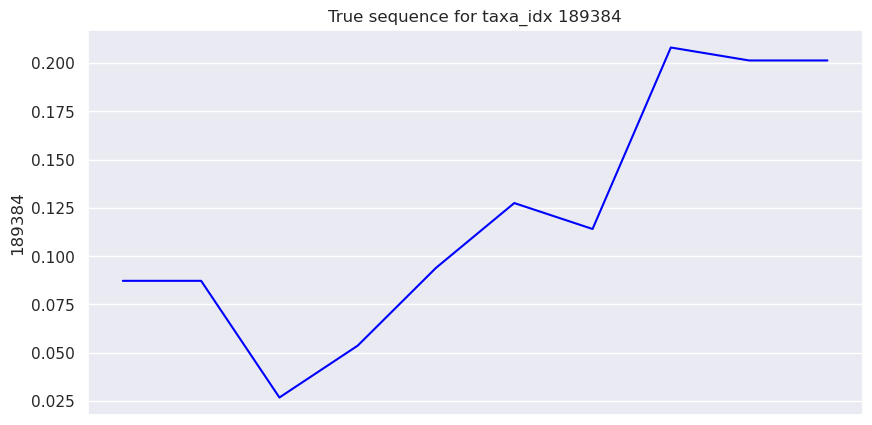

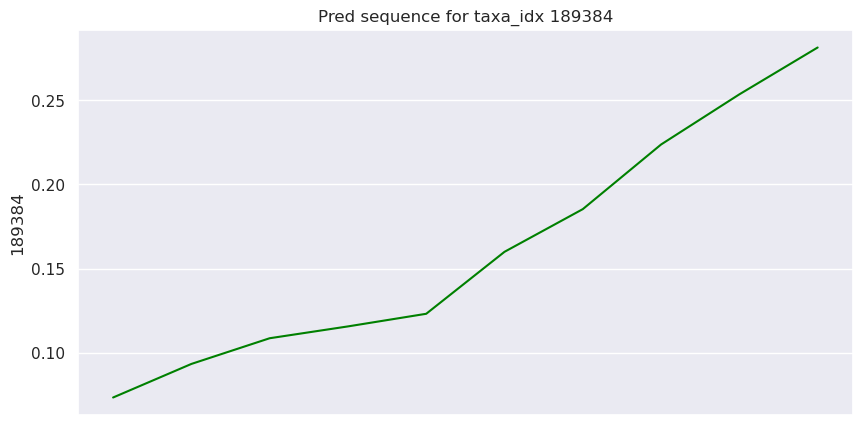

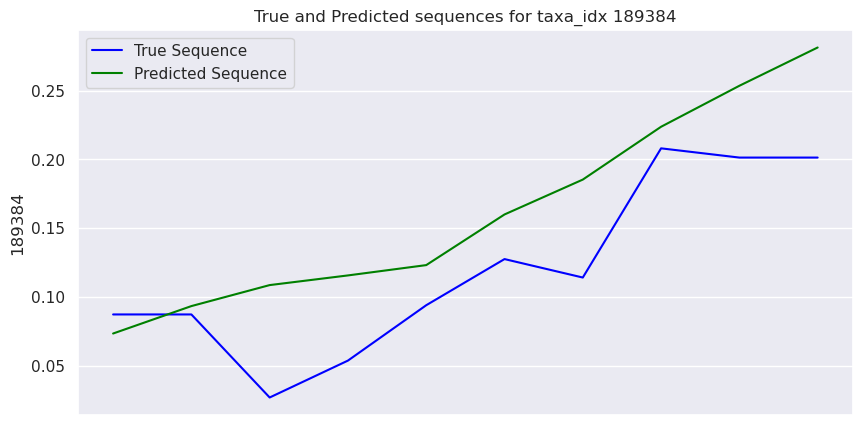

In [26]:
target_taxa = 189384

true_sequence = target_subject_y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = target_subject_y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [27]:
subjects_error_dfs = []
for target_subject_idx in range(len(test_subjects)):
    
    test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model_ensemble, df, target_subject_idx, test_feats, test_targets, experiment_id=2)

    errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
    subjects_error_dfs.append(errors_df)
    
errors_df = pd.concat(subjects_error_dfs)

Loading the models:   8%|▊         | 16/202 [00:19<03:44,  1.21s/it]2023-10-30 19:03:18.985081: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00MiB (rounded to 2097152)requested by op Identity
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-10-30 19:03:18.985522: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-10-30 19:03:18.985536: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 3506, Chunks in use: 3506. 876.5KiB allocated for chunks. 876.5KiB in use in bin. 15.3KiB client-requested in use in bin.
2023-10-30 19:03:18.985545: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 448, Chunks in use: 448. 250.0KiB allocated for chunks. 250.0KiB in use in bin. 224.0KiB client-r

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity] name: 

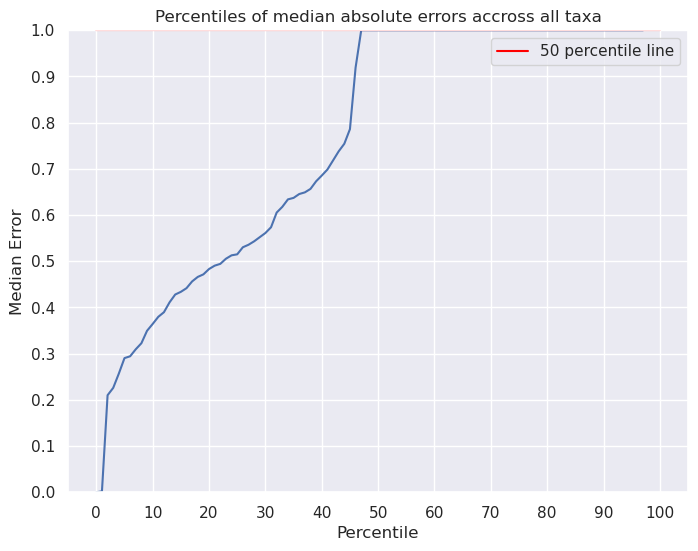

In [31]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=1)

In [32]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,659361,302746,3887769,585227,189384,3465320,1086274,309391,844375,509416,...,2283111,577170,359650,130663,3304236,193233,4334711,196664,583117,354850
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,38370069.530262,8853452.346087,0.604813,0.342082,0.687794,1.128642,98706099.026304,0.588274,12303201.206978,0.495012,...,946745.417022,0.826598,0.421366,26060971.174638,92528793.188043,0.675240,0.451288,1.226205,1.627556,0.942079
std,137939723.052373,40571610.525783,0.291158,0.333450,0.852478,1.702285,158674194.428433,0.256964,56380347.448488,0.270463,...,4338529.193560,0.774986,0.238757,82317382.640062,298224077.600244,0.452369,0.494007,1.181913,1.819484,1.351423
min,0.688557,0.048281,0.173198,0.016130,0.112026,0.064649,0.055659,0.057927,0.042540,0.045487,...,0.336025,0.033914,0.020151,0.004244,0.082269,0.069846,0.027262,0.026443,0.064574,0.038944
25%,1.000000,0.137953,0.409094,0.159201,0.256078,0.473253,0.663145,0.435546,0.509451,0.364490,...,0.594286,0.371203,0.339594,0.221744,0.361724,0.320320,0.208967,0.339450,0.682095,0.165603
50%,8.294287,0.293482,0.622903,0.241798,0.287678,0.602093,5.889162,0.646568,0.633811,0.455763,...,0.783324,0.563385,0.426484,0.399406,0.686218,0.644874,0.349379,0.612477,1.000000,0.489964
75%,17.223248,2.396534,0.742129,0.376193,0.521087,1.263434,122906249.016523,0.801570,0.809694,0.630824,...,0.854848,0.827770,0.565040,0.703843,0.929872,0.926681,0.493364,1.935943,1.802812,0.698728
max,629140213.131905,185922477.394342,1.422192,1.402513,3.156277,8.107804,420037247.240543,0.908542,258367210.626602,1.406287,...,19881639.163941,3.062948,0.855180,277366973.459721,1159591302.275658,1.714785,2.372083,3.769978,6.624441,4.991985


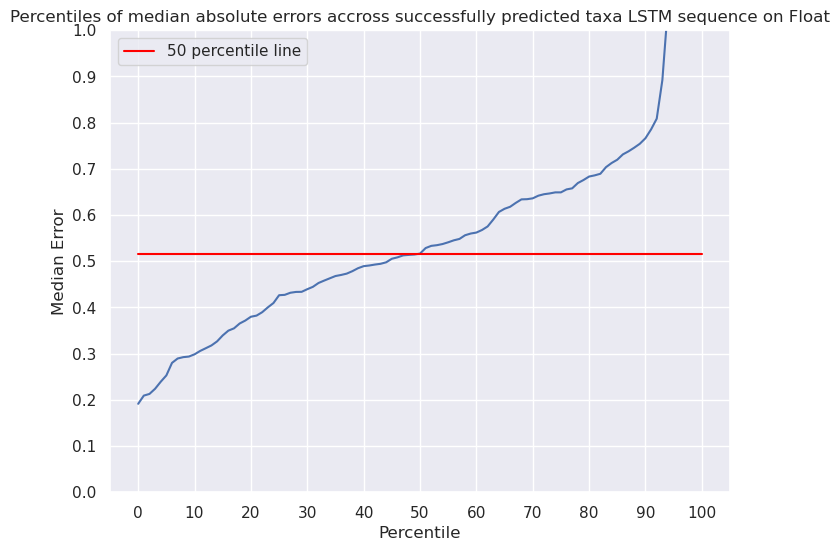

In [33]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa LSTM sequence on Float", y_top_lim=1)